## Author: Charlie Moffett
Principles of Urban Informatics @ NYU CUSP // Professor Federica Bianco // Fall 2017

This notebook was written in Python 3.

Table of Contents:
    1. Time Domain: An Exploratory Analysis
        1.1. Obtain historical data for 2000-2016 for all NYC police precincts
        1.2. Remove outliers/invalids
        1.3. Plot the time series for each of the seven major felonies (+ total)
        1.4. Calculate the mean and standard deviation in time for each precinct and each crime
        1.5. Plot the total crime time series clusters and discuss the clustering and trends
    2. Spatial Domain: Making the Connection
        2.1. Obtain NYC precincts geometry and read it in as a shapefile
        2.2. Merge the gdf with crime df and plot a choropleth of the clusters. 
        2.3. Download socioeconomic features dataset, to be used as exogenous variables.
        2.4. Pivot the crime dataframe
        2.5. Merge the 3 dataframes and map the seven major felonies (+ total).
        2.6. Cluster the data; first using the socioeconomic features, and then using the 7 felonies. 
        2.7. At last, create a function that generates a model based on socioeconomic features.

Motivation:

The study of NYC crime is of broad interest in the Urban Science scene, and NYPD has provided statistics on the crime (by precinct) for several years. This is an important resource to understand and analyze urban crime. There are obvious connections between crime and wealth, which relate both to access to precious goods (opportunity), and to how easy it is to commit a crime (neighborhood safety, or perceived safety). It's been suggested that unemployment correlates strongly with burglary, for example, due to both opportunity and motivation. In addition, research indicates that access to greenspace impacts crime rate.

In this presentation, we will explore and model NYC crime:

- The first part of the presentation is an exploratory analysis of the crime time series for the seven major felonies 2000-2016 (temporal domain).

- The second part of the presentation attempts to relate socioeconomic features to specific felony rates by area (spatial domain).

In [ ]:
# base imports
from __future__ import print_function, division
import geopandas as gpd
import pandas as pd
import numpy  as np
import os
import io
from io import StringIO

# plotting packages
import seaborn as sns
import matplotlib.cm as cm
import pylab as pl
%pylab inline

# python clustering with sklearn
from sklearn import cluster
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist

# python modeling with sklearn
from sklearn import cross_validation 
from sklearn import ensemble

import urllib.request
import urllib.error
import urllib

In [2]:
# Awhile ago, Professor Bianco wrote a quick function that plots choropleths and maps of NYC,
# specifically putting legends and colorbars in the empty spaces taking advantage of the shape of the city 
# source: https://github.com/fedhere/choroplethNYC

import choroplethNYC as cp

In [ ]:
# We'll be storing all of our data downloads here:
os.getenv("PUIDATA")

# 1. Time Domain: An Exploratory Analysis

### 1.1 Obtain historical data for 2000-2016 for all NYC police precincts

*To download and store the data in question, remove the double octothorpes ('##') from the following cells:*

In [4]:
# download 'Citywide Seven Major Felony Offenses 2000-2016' 
##!wget 'https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/seven-major' + 
##'felony-offenses-by-precinct-2000-2016.xls'

In [5]:
# move to $PUIDATA
##os.system("mv %s %s"%("seven-major-felony-offenses-by-precinct-2000-2016.xls", os.getenv("PUIDATA")))

*Upon inspecting the 2000-2016 data on major felony offenses by NYC precinct, we noticed that the PCT (precinct) column was showing NaN for most rows. The NaNs correspond to additional crimes for the same PCT, so we filled them in with preceding values. We've also skipped two superfluous header rows.*

In [6]:
# read in data
crime = pd.read_excel(os.getenv("PUIDATA") + "/" + "seven-major-felony-offenses-by-precinct-2000-2016.xls", skiprows = 2)
crime.PCT = crime.PCT.fillna(method='ffill')
crime.head(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0
2,1,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0


In [7]:
print("Shape of crime dataframe: {}".format(crime.shape))
print("True or False - There are nulls remaining: {}".format(crime.isnull().values.any()))

Shape of crime dataframe: (636, 19)
True or False - There are nulls remaining: True


*Though We've removed NaNs now from the PCT column, there are still null values for each year that we need to consider.*

## 1.2 Remove outliers/invalids

*We decided to completely drop any precincts with missing values rather than impute the felony counts for any given year. We lose 28 rows in the process, but lose just two precincts (123 & DOC) - which only have felony count values starting in 2013 & 2014 (respectively). What remain are 76 unique precincts.*

In [8]:
# showing NaNs in the tail (and bad values for PCT as well)
crime.tail(2)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
634,6. The 121 pct was created on 7-1-2013 from pa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
635,7. As of 1-1-2014 complaints occurring within ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# We remove the NaNs and bad PCT values with a single step
crime = crime.dropna()
crime.tail(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
613,123,GRAND LARCENY,101.0,90.0,116.0,137.0,166.0,233.0,175.0,181.0,191.0,171.0,147.0,175.0,183.0,171.0,194.0,163.0,145.0
614,123,GRAND LARCENY OF MOTOR VEHICLE ...,266.0,193.0,143.0,131.0,95.0,96.0,114.0,87.0,81.0,51.0,39.0,48.0,31.0,40.0,30.0,20.0,23.0
615,123,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,378.0,348.0,302.0


In [10]:
# We've gone from 636 to 608 rows
print("Shape of crime dataframe: {}".format(crime.shape))
print("True or False - There are nulls remaining: {}".format(crime.isnull().values.any()))

Shape of crime dataframe: (608, 19)
True or False - There are nulls remaining: False


In [11]:
# But my PCT values look great now
print("Number of Precincts: {}".format(len(crime.PCT.unique())))
print("\nFull list of Precincts: {}".format(crime.PCT.unique()))

Number of Precincts: 76

Full list of Precincts: [1 5 6 7 9 10 13 14 17 18 19 20 22 23 24 25 26 28 30 32 33 34 40 41 42 43
 44 45 46 47 48 49 50 52 60 61 62 63 66 67 68 69 70 71 72 73 75 76 77 78 79
 81 83 84 88 90 94 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 120 122 123]


In [12]:
# My ranges for felony counts seem peculiar, but that's only because one row per precinct contains the sum of all 7 felonies
crime.describe().round(1)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0,608.0
mean,607.4,535.9,509.2,483.8,467.4,445.6,423.3,398.1,388.0,351.1,345.8,350.9,366.7,364.4,346.5,342.1,329.8
std,884.4,790.1,737.7,698.5,674.3,633.5,597.7,565.0,549.0,499.6,488.4,494.8,518.3,520.2,497.7,491.2,481.2
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,57.8,56.8,52.5,48.8,49.0,44.8,38.0,37.0,33.8,32.0,31.0,29.0,30.0,27.8,29.0,30.0,28.8
50%,338.0,296.5,287.5,264.5,260.5,253.0,232.5,213.5,208.5,195.5,183.0,186.5,185.0,171.5,165.0,159.0,141.0
75%,645.0,580.2,559.5,522.5,493.0,469.5,456.5,434.0,429.8,394.0,394.5,403.5,431.0,434.0,412.8,388.5,384.8
max,6857.0,6088.0,5265.0,5105.0,4730.0,4423.0,4173.0,3971.0,3708.0,3330.0,3103.0,3393.0,3780.0,3902.0,3751.0,3506.0,3287.0


## 1.3  Plot the time series for each of the seven major felonies (+ total). 

*We're going to extract data for the seven major felonies (+ total) in order to plot a time series for each using pylab. There's a lot of data, however, and we'll need to transpose my dataframe in each instance in order to meaningfully organize the display of information.*

In [13]:
# transpose df for a single crime and re-index to remove non-numeric rows
# our code was inspired by the stackoverflow topic "Python script to transpose dataframe"
# source: https://stackoverflow.com/questions/45641947/python-script-to-transpose-dataframe
robbery = crime[crime['CRIME'] == 'ROBBERY                               '].iloc[:,2:].T
robbery.tail(2)

,2,10,18,26,34,42,50,58,66,74,...,530,538,546,554,562,570,578,586,602,610
2015,79.0,100.0,114.0,107.0,134.0,105.0,147.0,221.0,49.0,159.0,...,190.0,276.0,55.0,44.0,232.0,224.0,339.0,227.0,62.0,29.0
2016,60.0,102.0,120.0,129.0,152.0,94.0,116.0,201.0,65.0,163.0,...,213.0,260.0,46.0,50.0,192.0,212.0,349.0,200.0,82.0,19.0


*In order to plot the time series for each felony (+ total) in a concise manner, we construct a 'for loop' to iterate on both data viz & extraction.* 

*We also reformat each the names of each crime to derive cleaner plot titles.*

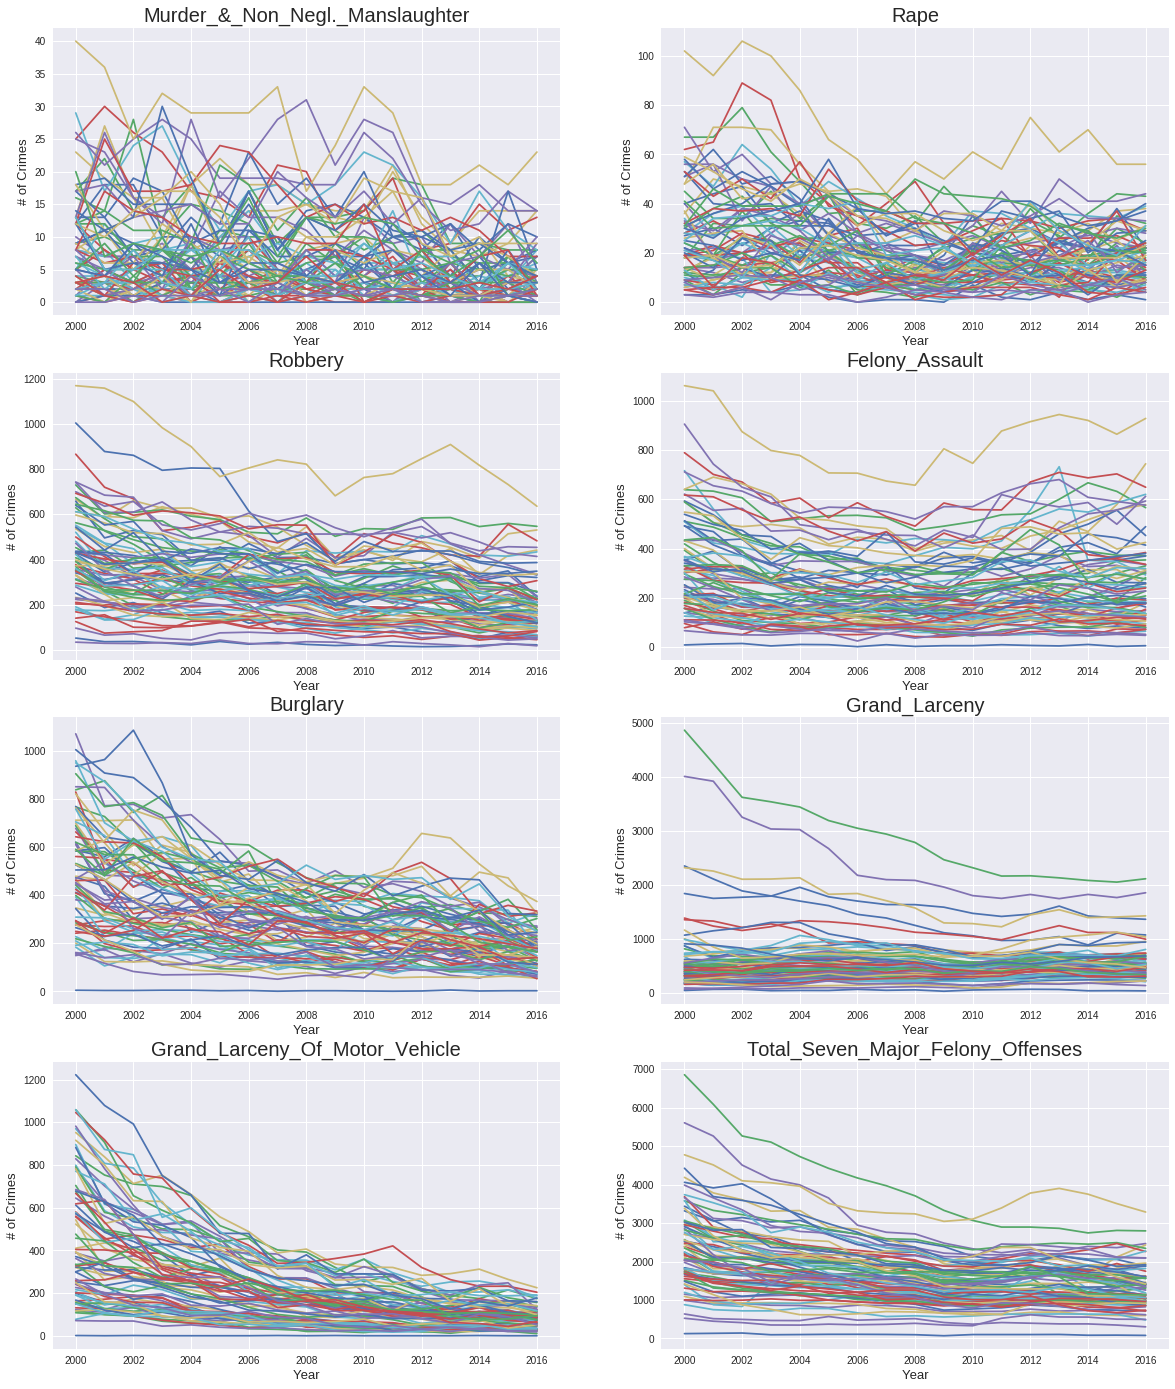

In [14]:
# plot the time series for each of the seven major felonies (+ total)
# our 'for loop' was inspired by "Simple Plotting in Python with matplotlib" from the Unidata Developer's blog
# source: https://www.unidata.ucar.edu/blogs/developer/entry/simple-plotting-in-python-with
fig = pl.figure(figsize=(20,75))
crime_names = crime.CRIME.unique()

for i in range(len(crime_names)):
    ax = fig.add_subplot(12, 2, i+1)
    ax.plot(crime[crime['CRIME'] == crime_names[i]].iloc[:,2:].T)
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylabel('# of Crimes', fontsize=16)
    ax.set_title(crime_names[i].strip().replace(" ","_").title(), fontsize=20)

__*Figure 1: In this set of 8 visualizations, we plot the time series for each of the seven major felonies as well as for the total (aggregation of all felonies). There's a lot of information to digest since we have 76 precincts to display for each crime type, but we can get a sense for the general trend in NYC across the time period 2000-2016. For a number of crimes (e.g. Grand Larceny, Burglary) we can see a trend of decreasing offense counts, but for others (e.g. Murder & Non-Negligent Manslaughter) the trend is less obvious.*__ 

*We dig deeper into our exploratory analysis in the following steps, and employ a little help from clustering to partition our time series.*

## 1.4 Calculate the mean and standard deviation in time for each precinct and each crime

*We'll take the mean and standard deviation by row for complete rows (e.g. we won't impute any values).*

In [15]:
# calculate the mean in time for each precint and each crime
# add the mean as a new column to my existing dataframe
crime['crimemean'] = crime.mean(axis=1)
crime.head(2)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,crimemean
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.058824
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0,8.588235


In [16]:
# The years are poorly formatted -- some read as int some as strings
cols = {'2006':2006, '2007':2007, '2008':2008, '2009':2009, '2011':2011, 2016:'2016'}
crime = crime.rename(columns=cols)

# calculate the standard deviation in time for each precint and each crime
# add the stdev as a new column to our existing dataframe
crime['stdev'] = crime.loc[:, 'CRIME':'2016'].std(axis=1)
crime.head(2)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,crimemean,stdev
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,...,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.058824,0.966345
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,...,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0,8.588235,3.063063


*As the table above shows, we've calculated the mean and stdev in time for each precinct and each crime, and stored them as columns in our crime dataframe.*

## 1.5 Plot the total crime time series clusters and discuss the clustering and trends.

In [17]:
# store in a new dataframe 'totcrime' the total crime row for each precinct
totcrime = crime[crime['CRIME'] == 'TOTAL SEVEN MAJOR FELONY OFFENSES']
totcrime.head(2)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,crimemean,stdev
7,1,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,...,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0,1970.588235,674.856379
15,5,TOTAL SEVEN MAJOR FELONY OFFENSES,1780.0,1458.0,1309.0,1231.0,1170.0,1131.0,1040.0,1031.0,...,975.0,969.0,962.0,1001.0,980.0,870.0,917.0,899.0,1103.058824,233.630443


*Above we've extracted the total crime row for each precinct ('PCT'). we will begin clustering the time series.*

*I've elected to a perform K-Means clustering method, which would normally require that I standardize along the feature vectors in order to whiten the data. However, because we are clustering time series, we don't want to modify the timestamps separately. We want to cluster on the correlated behaviors of the variables (years), so we will instead normalize and standarize each observation (totals for the seven major felony offenses of each precinct).*

In [18]:
# transpose the dataframe to prepare for observational standardization
# remove rows containing strings
totcrime_flip = totcrime.T[2:-2]
totcrime_flip = totcrime_flip.T

# standarize by subtracting the mean from each observation and dividing by stdev
vals = ((totcrime_flip.T - totcrime_flip.mean(1)) / totcrime_flip.std(1)).T

*I'm not engaged in particularly rigorous clustering analysis here, so I won't obsess over the right number of clusters.*

In [19]:
# K-Means clustering: the essential parameter is the number of clusters.
# source: https://github.com/fedhere/PUI2017_fb55/blob/master/final/preprocessinANDclustering.ipynb
no_clu = 5
km = cluster.KMeans(n_clusters=no_clu, random_state=111) # random state ~ setting the seed; ensures reproducibility
km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=111, tol=0.0001,
    verbose=0)

*The K-Means object does however have some relevant attributes, including cluster labels and cluster centers. The labels let me know which cluster a given observation (precint) belongs to, and the centers (naturally) give me an idea as to the location of the centers.*

In [20]:
print("Cluster labels as 1D array:\n\n {}".format(km.labels_))
print()
print("Cluster centers as NcxNf-dimentional array:\n\n {}".format(km.cluster_centers_))

Cluster labels as 1D array:

 [1 1 1 1 1 4 1 1 1 1 1 1 0 1 1 2 1 4 1 1 1 1 3 3 1 1 3 1 1 3 3 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 3 1 1 1 0 1 1 1 0 1 2 3 3 1 1 1 1 3 1 1 1 1 1 1 0 1 1 0
 0 0]

Cluster centers as NcxNf-dimentional array:

 [[ 2.09645697  1.24942272  0.95799842  0.36449217  0.37209671  0.44310235
   0.1614011   0.18694686  0.12903294 -0.61344146 -0.40389522 -0.22456386
  -0.03275326 -0.61050842 -1.12988946 -1.37925111 -1.56664746]
 [ 2.15206227  1.38183873  1.16488206  0.8804146   0.6806152   0.43305747
   0.17999277 -0.19219367 -0.34255857 -0.77688854 -0.82838598 -0.79402721
  -0.64120971 -0.64784171 -0.79574745 -0.83581097 -1.01819927]
 [ 0.91265919  0.20069661  0.45886647  0.87567744  0.6835901   0.5597093
   0.21029491 -0.33484314 -0.38056622 -1.74916999 -1.3831333  -2.20114454
  -0.08005754  0.96565831  0.49201025  0.81474694 -0.04499478]
 [ 2.55606841  0.99831999  0.39752852  0.02531894 -0.1334303  -0.36625572
  -0.46559285 -0.56651404 -0.55283047 -0.92581681 -0.91673472

*Since I (arbitrarily) specified 5 clusters, we see 5 (0,1,2,3,4) cluster labels. The cluster centers are presented as an NcxNf-dimentional array, where Nc = number of clusters & Nf = number of features (total crime by precinct). I'll save the labels as a column and plot my centers to confirm sanity.*

In [21]:
# create cluster labels column for dataframe plotting
totcrime_flip['CLUSTER_LBLS'] = km.labels_
totcrime_flip.head(2)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,CLUSTER_LBLS
7,3438,3069,2715,2649,2383,2305,2013,1914,1708,1578,1445,1402,1416,1416,1208,1446,1395,1
15,1780,1458,1309,1231,1170,1131,1040,1031,1029,975,969,962,1001,980,870,917,899,1


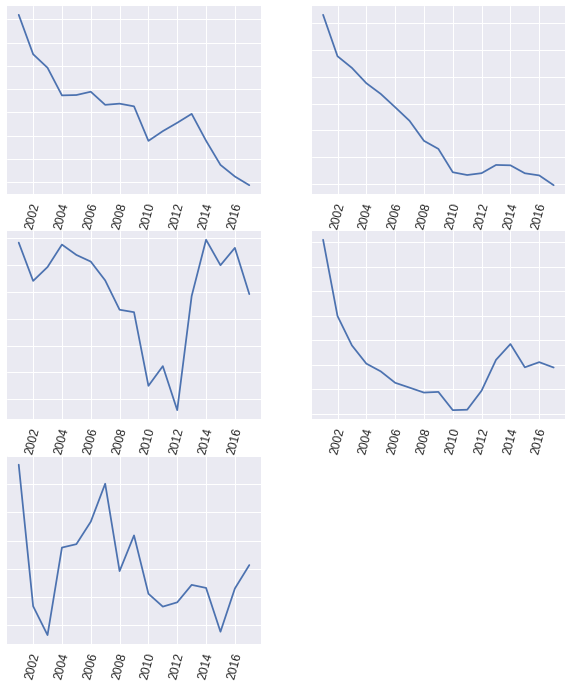

In [22]:
# plotting my 5 K-Means cluster centers
# we've borrowed a significant portion of this code from Professor Bianco's "HW11_Assignment1_solution" notebook
# source: https://github.com/fedhere/PUI2017_fb55/blob/master/HW11_fb55/HW11_Assignment1_solution.ipynb
fig = pl.figure(figsize=(10, 20))
timespan = pd.date_range('2000', '2017', freq='A') # creating the date range: 2000-2016
for i, Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5, 2, (i + 1))
    ax.plot(timespan, Xc)
    pl.xticks(fontsize=12, rotation=75)
    ax.set_yticklabels(['' * len(ax.get_xticklabels())])

__*Figure 2: Cluster centers for 5 K-Means clusters of time series patterns (# of total crime offenses for the major seven felonies) at the precinct for NYC police precincts.*__

*Given that our cluster centers appear reasonable at a glance, we will plot the cluster members (precincts) along with them now.*

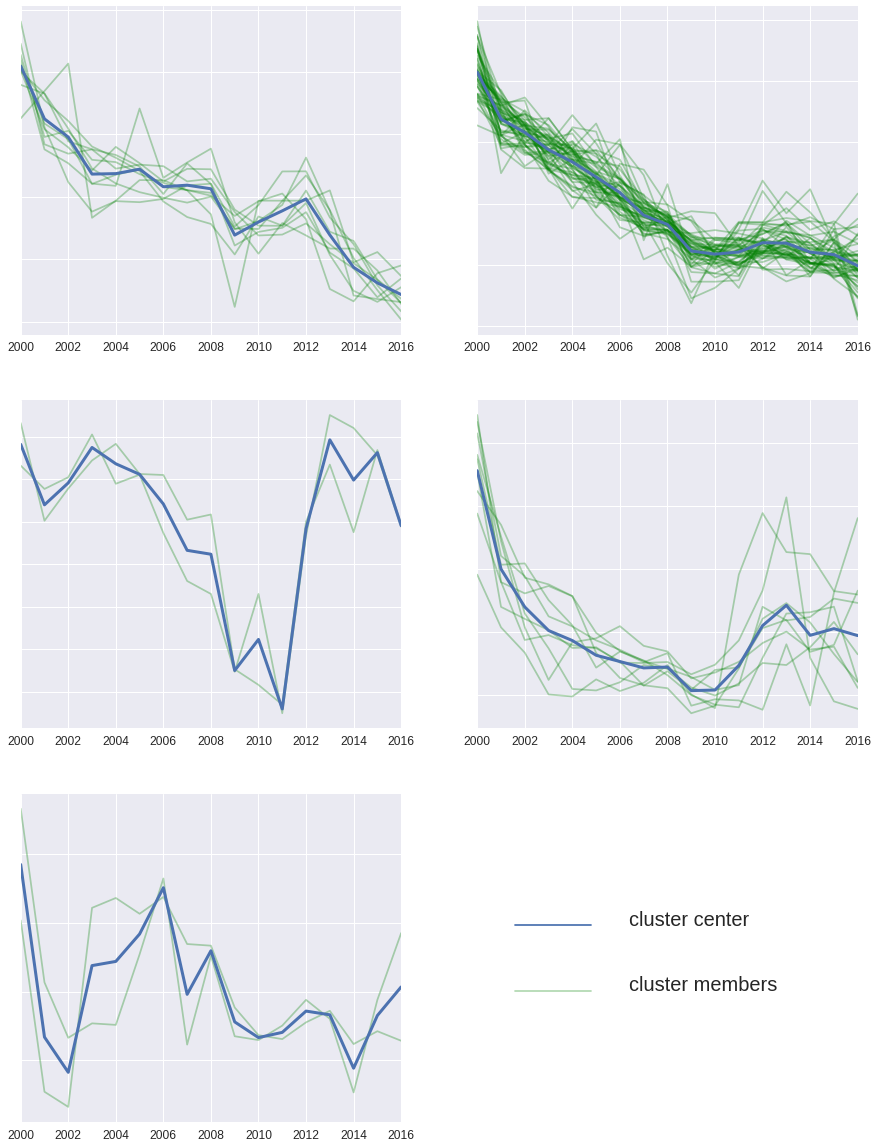

In [23]:
# plotting the cluster members along with the cluster centers
# we've borrowed a significant portion of this code from Professor Bianco's "HW11_Assignment1_solution" notebook
# source: https://github.com/fedhere/PUI2017_fb55/blob/master/HW11_fb55/HW11_Assignment1_solution.ipynb
fig = pl.figure(figsize=(15, 35))
for i, Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5, 2, (i + 1))

    for s in vals.values[km.labels_ == i]:
        ax.plot(np.arange(2000, 2017, 1), s, 'g-', alpha=0.3)

    ax.set_yticklabels(['' * len(ax.get_xticklabels())])
    ax.plot(np.arange(2000, 2017, 1), Xc, lw=3)
    pl.xticks(fontsize=12)
    ax.set_xlim(2000, 2016)
ax = fig.add_subplot(5, 2, i + 2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.plot([0.1, 0.3], [0.4, 0.4], 'g-', alpha=0.3)
ax.plot([0.1, 0.3], [0.6, 0.6], '-')
ax.text(0.4, 0.6, "cluster center", fontsize=20)
ax.text(0.4, 0.4, "cluster members", fontsize=20)
tmp = ax.axis('off')

__*Figure 3: Cluster centers and members for 5 K-Means clusters of time series patterns (# of total crime offenses for the major seven felonies) at the precinct for NYC police precincts. As we can see from these plots, we have convincing clusters that do indeed display homogeneous trends that differ between clusters.*__

*Precincts correspond to a meaningful geography for NYC - each precinct represents ageographical area patrolled by a police force. In the next steps, we'll visualize my data in such a manner as to capture the spatial domain component.*

# 2. Connecting the temporal and spatial components.
### 2.1 Obtain NYC precincts geometry and read it in as a shapefile.

*We found NYC Police Precincts as a standalone zip from https://catalog.data.gov/dataset?tags=gis&organization=city-of-new-york*

*When you download a shapefile, you actually download a zipped folder which contains the shape file and other files that are necessary to read the shape file in. We do so with the urllib library in Python 3.*

*To download and store the data in question, remove the double octothorpes ('##') from the following cells:*

In [24]:
# source: https://catalog.data.gov/dataset?tags=gis&organization=city-of-new-york
url = "https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile"

# the following methods for obtaining NYC precincts geometry were inspired by Prof. Bianco's "Census Geospatial Analysis"
# source: https://github.com/fedhere/PUI2017_fb55/blob/master/HW9_fb55/geopandas_census_solution.ipynb
##urllib.request.urlretrieve(url, "police_precincts.gz")

In [25]:
# unpacks the data into my PUIdata directory
##!unzip -d $PUIDATA police_precincts.gz

In [26]:
# read in the police precincts shapefile with geopandas:
patrol_nyc = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + 
                                    "geo_export_2c8683e7-fae4-4e07-af30-f8c6b776081e.shp")

In [27]:
# for it to be a valid geodataframe, it needs to contain the column “geometry”
patrol_nyc.tail(3)

,precinct,shape_leng,shape_area,geometry
74,121.0,138115.721207,4.757161e+08,(POLYGON ((-74.15945602438185 40.6414483333240...
75,122.0,154881.006310,4.547993e+08,(POLYGON ((-74.05050806403284 40.5664220346634...
76,123.0,120885.302710,4.608638e+08,POLYGON ((-74.16982656393461 40.56107800369057...


## 2.2 Merge the gdf with crime df and plot a choropleth of the clusters. 

In [28]:
# add back in column containing precinct numbers
vals['PCT'] = totcrime['PCT']

# add back in column containing cluster numbers
vals['Clusters'] = totcrime_flip['CLUSTER_LBLS'] 

# convert shapefile precinct number column values from float to integer
patrol_nyc['precinct'] = patrol_nyc[['precinct']].astype(int)

# merge the precincts gdf with my crime df
# I should have 75 precincts (dropped a precinct with bad data from crime earlier)
crimeshp = patrol_nyc.merge(vals, left_on="precinct", right_on="PCT", copy=False)

# drop superfluous precinct numbers column
crimeshp = crimeshp.drop(labels='PCT', axis=1)

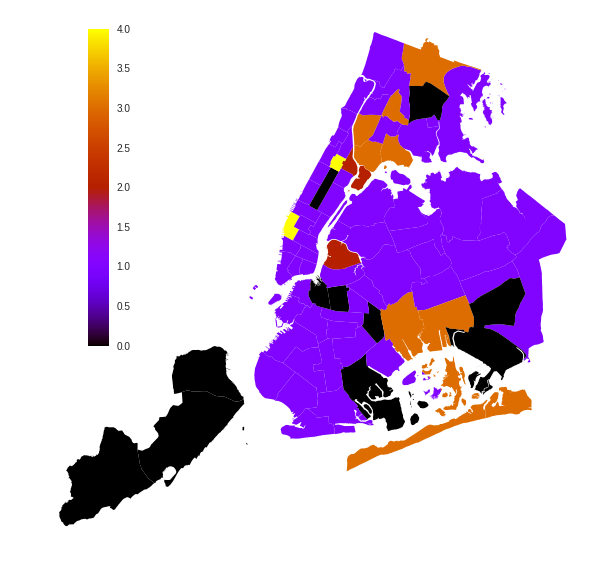

In [29]:
# plot a cloropleth of the clustered total crime time series using precinct geography
# source: HW9 Solutions - https://github.com/fedhere/PUI2017_fb55/blob/master/HW9_fb55/geopandas_census_solution.ipynb
cp.choroplethNYC(crimeshp, column="Clusters", cmap="gnuplot");

__*Figure  4:  Cluster labels (k=5) from time series clustering analysis (K-Means) on total number of crime incidents (within the seven major felony offenses) at the police precinct level of granularity. Cluster assignments are integers in range 0-4. Precincts in red represent cluster label 2, where the trend for total crime has been positive (increase in total crime over the time period 2000-2016), and include parts of Harlem and Greenpoint. The trend for remaining clusters has been generally negative (decrease in total crime) or neutral.*__

*__Discussion of spatial coherence:__ does the geographical information help interpret the trends you see in time domain?*

*From the mapped cluster labels we indeed notice some trends in the time domain. All three precints in Staten Island, for example, belong to the same cluster (#0). Other precincts however appear to buck the trend in their region, as we've mentioned in the figure caption.*


## 2.3 Download socioeconomic features dataset, to be used as exogenous variables. 

*Professor Bianco has so kindly aggregated median income and percent unemployed at the precinct level from the native census tract geometry, extracted from the 2015 5-year ACS survey. She also calculated the percent area of a precinct that is occupied by "a green or park area". 

*We will access this file via an SQL query from CARTO (https://carto.com/).*

In [30]:
# SQL CARTO query function lifted from Prof. Bianco's HW7 instructions,
# source: https://github.com/fedhere/PUI2017_fb55/blob/master/HW7_fb55/SQL_query.ipynb
# and made Python 3-compatible in my HW7, Assignment 2, Extra Credit submission
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

def queryCARTO(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - output format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urllib.parse.urlencode({'format': format, 'q': query})
    data = data.encode("utf-8")
    try:
        response = urllib.request.urlopen(source, data)
    except urllib.error.HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [31]:
# creates a variable 'query' from our sql query string as string type
# extracts only columns relevant to our socioeconomic analysis
query = '''SELECT precinct, green, medianincome, unemployment FROM nycsocioeconomicsbyprecinct'''

In [32]:
# read in CSV returned from CARTO dataset query
socioeconomics = pd.read_csv(io.BytesIO(queryCARTO(query)), sep=',')

In [33]:
socioeconomics.head()

,precinct,green,medianincome,unemployment
0,1,0.058702,124092.068749,0.021444
1,60,0.173512,35015.008703,0.056448
2,61,0.238375,65998.923662,0.055458
3,63,0.158530,33655.205265,0.031215
4,24,0.166040,113966.467973,0.043461


*Now we have a dataframe that can help us relate socioeconomic features to crime rate by area (spatial domain).*

## 2.4 *Pivot* the crime dataframe

In [34]:
# my crime df currently has a column for each year, with the crime names as the row index
crime.head(2)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,crimemean,stdev
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,...,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.058824,0.966345
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,...,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0,8.588235,3.063063


In [35]:
# pivoting crime df for new dataframe with felonies on the columns, instead of the rows
crimepivot = crime.pivot(index='PCT', columns='CRIME', values='crimemean')

In [36]:
crimepivot.head(3)

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES
PCT,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059


## 2.5 Merge socioeconomic data with pivoted crime df and precinct gdf. 
### Plot a choropleth of each of the 7 felonies, plus the total crime by precinct.

In [37]:
# merge 2015 ACS Survey data with precints numbers for the seven major felonies (+ total)
crime_ACS = crimepivot.merge(socioeconomics, left_index=True, right_on='precinct')

In [38]:
# only columns left are 7 felonies, total, and socio-economic features
crime_ACS.head(2)

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES,precinct,green,medianincome,unemployment
0,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235,1,0.058702,124092.068749,0.021444
30,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824,5,0.049462,99148.860914,0.046260


In [39]:
# rename the crime features
# column cleaning help from stackoverflow
# source: https://stackoverflow.com/questions/41476150/removing-space-from-dataframe-columns-in-pandas
crime_ACS.columns = crime_ACS.columns.str.replace(' ', '')
crime_ACS.columns

Index(['BURGLARY', 'FELONYASSAULT', 'GRANDLARCENY',
       'GRANDLARCENYOFMOTORVEHICLE', 'MURDER&NONNEGL.MANSLAUGHTER', 'RAPE',
       'ROBBERY', 'TOTALSEVENMAJORFELONYOFFENSES', 'precinct', 'green',
       'medianincome', 'unemployment'],
      dtype='object', name='CRIME')

In [40]:
# merge with precinct gdf
crimeshp = crimeshp[['precinct', 'shape_leng', 'shape_area', 'geometry', 'Clusters']]
crimeshp_ACS = crimeshp.merge(crime_ACS)

*We've now merged our socioeconomic data with the pivoted crime dataframe, as well as the precinct geodataframe.*

*Time to inspect how these clusters are influenced by geography - spatial coherence can be very telling for socioeconomic (and criminal justice) phenomena.*

Order:
Burglary
Felony Assault
Grand Larceny
Grand Larceny of Motor Vehicle
Murder and Non-negligent Manslaughter
Rape
Robbery
Total - Seven Major Felony Offenses


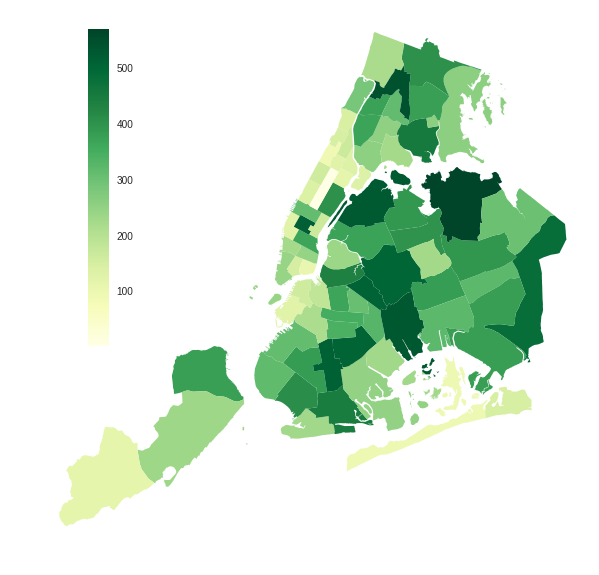

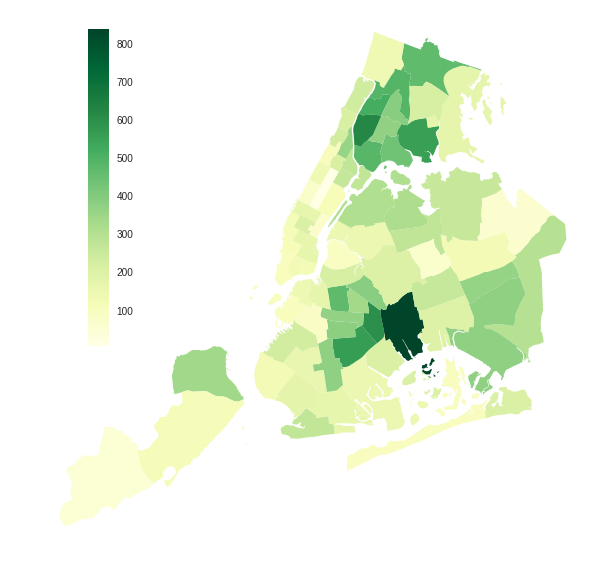

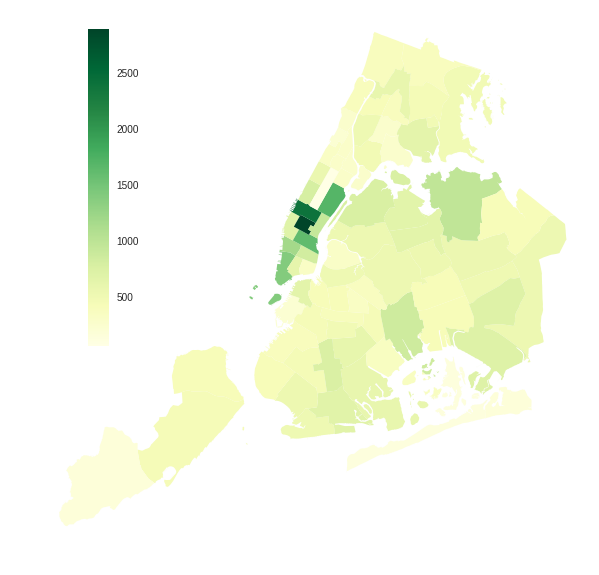

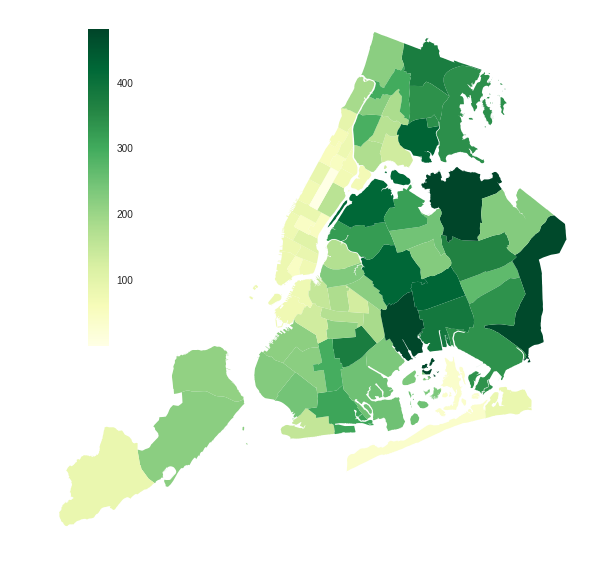

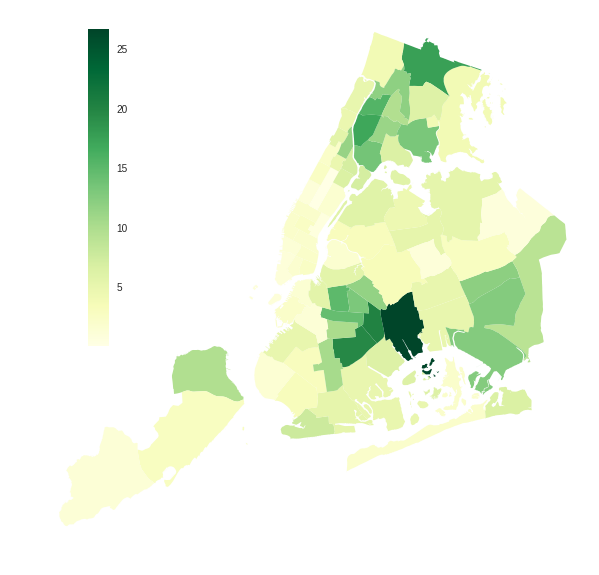

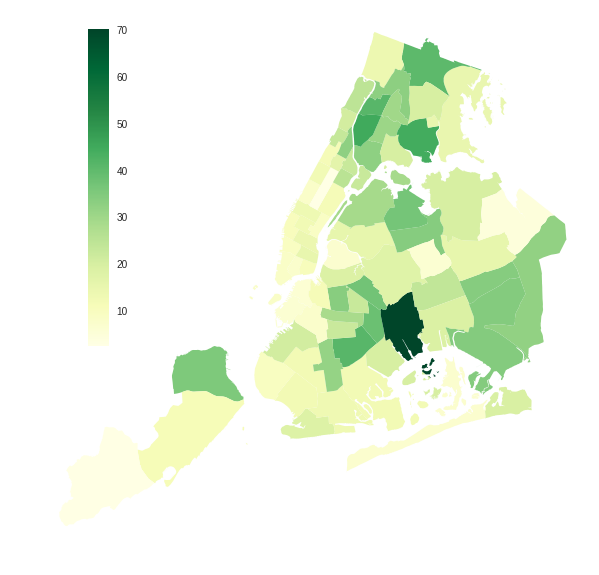

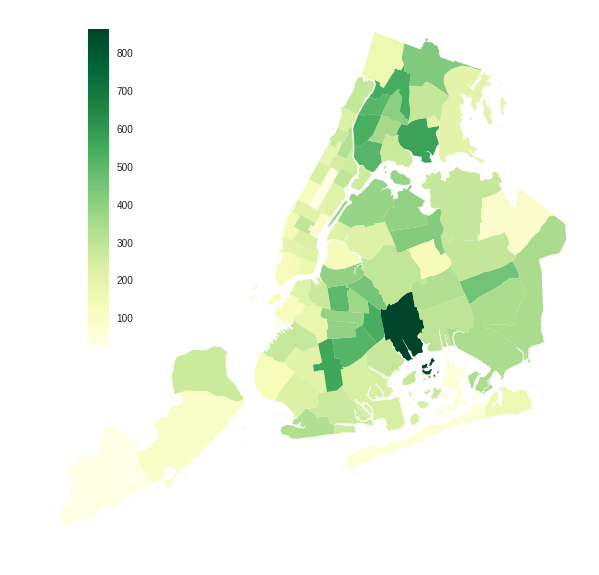

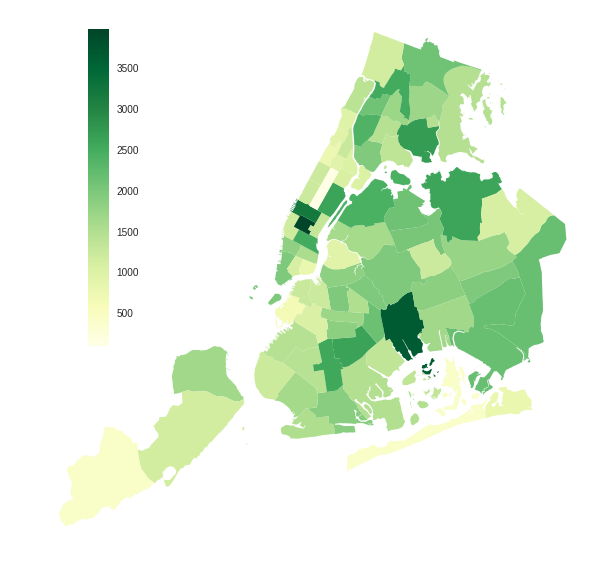

In [41]:
# plot a choropleth of each of the 7 felonies, plus the total crime by precinct
print("Order:")
print("Burglary")
cp.choroplethNYC(crimeshp_ACS, column="BURGLARY", cmap="YlGn");
print("Felony Assault")
cp.choroplethNYC(crimeshp_ACS, column="FELONYASSAULT", cmap="YlGn");
print("Grand Larceny")
cp.choroplethNYC(crimeshp_ACS, column="GRANDLARCENY", cmap="YlGn");
print("Grand Larceny of Motor Vehicle")
cp.choroplethNYC(crimeshp_ACS, column="GRANDLARCENYOFMOTORVEHICLE", cmap="YlGn");
print("Murder and Non-negligent Manslaughter")
cp.choroplethNYC(crimeshp_ACS, column="MURDER&NONNEGL.MANSLAUGHTER", cmap="YlGn");
print("Rape")
cp.choroplethNYC(crimeshp_ACS, column="RAPE", cmap="YlGn");
print("Robbery")
cp.choroplethNYC(crimeshp_ACS, column="ROBBERY", cmap="YlGn");
print("Total - Seven Major Felony Offenses")
cp.choroplethNYC(crimeshp_ACS, column="TOTALSEVENMAJORFELONYOFFENSES", cmap="YlGn");

__*Figure 5: Choropleths showing the mean number of crimes across the period 2000-2016 for each of the 7 felonies, plus the total crime by precinct.*__

*There are a few interesting trends worth pointing out here. The mean crime counts across our timespan for felony assaults, robberies, rapes, and murders are highest in East New York. It's widely considered the worst neighborhood in New York City, and one of worst for crime in the entire nation (source: http://digg.com/2016/what-the-hell-happened-in-east-new-york).*

*Grand larceny is disproportionately prevalent in Lower Manhattan, however -- particularly in Midtown. This makes sense if we consider the motivation aspect of personal property theft. There are a lot of valuables in Midtown to motivate grand larceny - 'think purse snatchings and credit card thefts' (source: https://www.dnainfo.com/new-york/20110908/midtown/midtown-has-highest-per-capita-crime-rate-new-york).*

## 2.6 Cluster the data; first using the socioeconomic features, and then using the 7 felonies. 

*Insights from Lab 12: https://github.com/fedhere/PUI2017_fb55/blob/master/Lab12_fb55/LocationLocationLocation.ipynb*

In [42]:
# creating new df for socioeconomic features
econ = crimeshp_ACS.set_index(keys='precinct', drop=True)
econ = econ.filter(['green', 'medianincome', 'unemployment'])
econ.head(2)

,green,medianincome,unemployment
precinct,,,
1,0.058702,124092.068749,0.021444
5,0.049462,99148.860914,0.046260


In [43]:
# let's have a look at some of the key moments in our ACS data
econ.describe()

,green,medianincome,unemployment
count,76.000000,76.000000,76.000000
mean,0.108151,58386.872692,0.057894
std,0.137692,36905.003541,0.031301
min,0.006469,5.015011,0.021444
25%,0.029609,32424.124626,0.037523
50%,0.058819,56228.917906,0.053081
75%,0.136045,77363.797400,0.071554
max,0.953881,138375.366872,0.249993


In [44]:
# which precincts have astronomically high median income?
print(econ.loc[econ['medianincome'] > 130000])
print("\nMidtown South, Upper East/West Sides, and Downtown Brooklyn (respectively)")

             green   medianincome  unemployment
precinct                                       
14        0.022124  133690.008536      0.034299
19        0.026093  138375.366872      0.024351
20        0.118210  131007.496796      0.027085
84        0.066363  131474.922215      0.044577

Midtown South, Upper East/West Sides, and Downtown Brooklyn (respectively)


In [45]:
# which precincts have the lowest median income?
print(econ.loc[econ['medianincome'] < 2000])
print("\nThe Bronx (is Burning) - source: https://nypost.com/2010/05/16/why-the-bronx-burned/")

             green  medianincome  unemployment
precinct                                      
22        0.953881      5.015011      0.249993
41        0.039315    545.791703      0.069079
42        0.139640   1227.073655      0.082981

The Bronx (is Burning) - source: https://nypost.com/2010/05/16/why-the-bronx-burned/


*We considered dropping a few precincts with particularly low median incomes, but couldn't justify it. Precincts 41 & 42 are in the Bronx, and from what we could gather, these figures are (disturbingly) legitimate. We proceed then with preprocessing.*

In [46]:
# whiten the data by standardizing along the feature vectors
Xs = preprocessing.scale(econ, axis=0)

*This time around I get a bit more rigorous in choosing the number of clusters (k) for K-Means with regard to socioeconomic features. I explore both the silhouette score and the elbow method. I'll use a simple Euclidean distance, since these are all numerical features.*

In [47]:
# The silhouette score quantifies each data point's attachment to its current cluster vs. the closest neighbor cluster 
# Our methodology is inspired by Lab 8 from Applied Data Science with Prof. Sobolevsky
range_n_clusters = [2, 3, 4, 5, 6] # run it on k = 2, 3, etc.
for n_clusters in range_n_clusters: # computes silhouette score
    km = cluster.KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(econ)
    silhouette_avg = silhouette_score(econ, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.5517499386747736
For n_clusters =3, the average silhouette_score is :0.6046763426269418
For n_clusters =4, the average silhouette_score is :0.59709707823621
For n_clusters =5, the average silhouette_score is :0.5758347712323557
For n_clusters =6, the average silhouette_score is :0.5701548641288909


*The silhousette scores give a starting point to consider the optimal number of clusters to use with our socioeconomic data. But, as they say, a picture is worth 1000 words - when we do cluster analysis, visualization is very important. The credibility of our clusters is hard to understand otherwise. And so I'll utilize the elbow method to further demonstrate.*

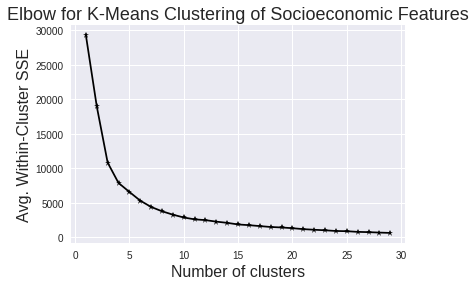

In [48]:
# The elbow method looks at the percentage of variance explained as a function of the number of clusters
# We're looking for the point at which marginal gain drops, giving an angle in the graph
# Our methodology is inspired by Lab 8 from Applied Data Science with Prof. Sobolevsky
data = econ

def elbow(data,K):
    KM = [cluster.KMeans(n_clusters=k).fit(data) for k in K]
    centroids = [k.cluster_centers_ for k in KM] # Save the centroids for each model with a increasing k 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids] # For each k, get distance b/w data & each center
    globals()['dist'] = [np.min(D,axis=1) for D in D_k] # distance to nearest centroid
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]  # calculate average sum of squared error (SSE)
    
    # "elbow" curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'k*-')
    plt.grid(True)
    plt.xlabel('Number of clusters', fontsize = 16)
    plt.ylabel('Avg. Within-Cluster SSE', fontsize = 16)
    plt.title('Elbow for K-Means Clustering of Socioeconomic Features', fontsize = 18)
    plt.show()
    
elbow(data, range(1,30))

__*Figure 6: Elbow plots showing variance (sum of squared error) between clusters against the number of clusters for the socioeconomic dataset. The more clusters, the smaller the sum of cluster variances. Around K = 3 or 4, variance begins decreasing more slowly -- this is where we'd want to stop adding clusters.*__

In [49]:
# The "elbow" plotted above cannot always be unambiguously identified. We like the idea of 4 clusters more than 3.
# K-Means clustering: the essential parameter is the number of clusters.
Nc = 4
km_econ = cluster.KMeans(n_clusters=Nc, random_state=111) # random state ~ setting the seed; ensures reproducibility
km_econ.fit(Xs);

*Given the spatial component of the precinct-level observation of ACS features, I will also visualize the cluster labels on a map to inspect spatial cohesion.*

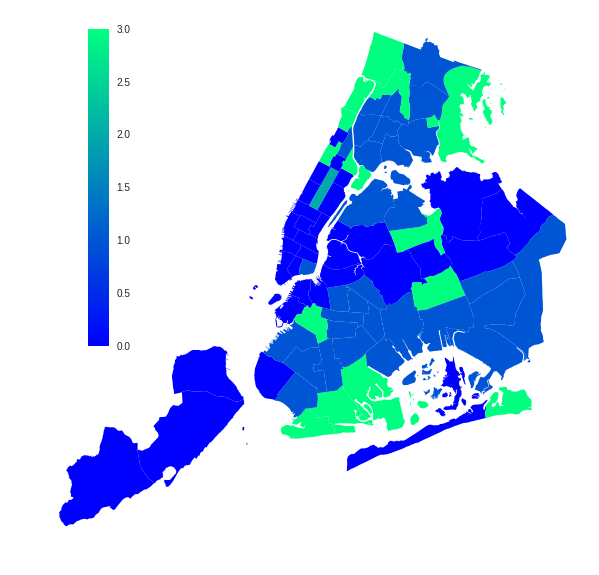

In [50]:
# plot cloropleth of socioceconomic feature clusters by precinct
crimeshp_ACS['clust'] = km_econ.labels_
cp.choroplethNYC(crimeshp_ACS, column="clust", cmap="winter");

__*Figure 7: Cloropleth of the K-Means cluster labels by NYC precinct for our three socioeconomic features (unemployed fraction, median income, and portion of precinct comprised of greenspace).*__

*The map demonstrates the significant degree of spatial cohesion pertaining to the socioeconomic features we've captured at the precinct level. Wealthier areas are clustered together - lower Manhattan (not including the Lowest East Side) and Downtown Brooklyn (post-2000). Historically marginalized areas are also grouped - parts of Harlem, the Bronx, and the eastern section of Brooklyn.* 

*Let's find out next whether clusters and outliers are preserved for the seven felonies in our next cloropleth.*

In [51]:
# creating new df for crime features
krime = crimeshp_ACS.set_index(keys='precinct', drop=True)
krime = krime.filter(['BURGLARY', 'FELONYASSAULT', 'GRANDLARCENY', 'GRANDLARCENYOFMOTORVEHICLE',
                   'MURDER&NONNEGL.MANSLAUGHTER', 'RAPE', 'ROBBERY'])
krime.head(2)

,BURGLARY,FELONYASSAULT,GRANDLARCENY,GRANDLARCENYOFMOTORVEHICLE,MURDER&NONNEGL.MANSLAUGHTER,RAPE,ROBBERY
precinct,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824


In [52]:
# whiten the crime data by standardizing along the feature vectors
Xscaled = preprocessing.scale(krime, axis=0)

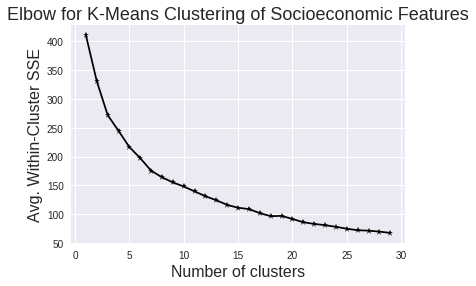

In [53]:
# plot elbow to determine reasonable number of clusters
def elbow(data,K):
    KM = [cluster.KMeans(n_clusters=k).fit(krime) for k in K]
    centroids = [k.cluster_centers_ for k in KM] # Save the centroids for each model with a increasing k 
    D_k = [cdist(krime, cent, 'euclidean') for cent in centroids] # For each k, get distance b/w data & each center
    globals()['dist'] = [np.min(D,axis=1) for D in D_k] # distance to nearest centroid
    avgWithinSS = [sum(d)/krime.shape[0] for d in dist]  # calculate average sum of squared error (SSE)
    
    # "elbow" curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'k*-')
    plt.grid(True)
    plt.xlabel('Number of clusters', fontsize = 16)
    plt.ylabel('Avg. Within-Cluster SSE', fontsize = 16)
    plt.title('Elbow for K-Means Clustering of Socioeconomic Features', fontsize = 18)
    plt.show()
    
elbow(krime, range(1,30))

__*Figure 8: Elbow plots showing variance (sum of squared error) between clusters against the number of clusters for the felonies dataset. It is much harder to see the "elbow" for this set of features! I will continue to use k = 4 however since we want to find out whether the groupings from our ACS features have been preserved for the crime insights.*__

In [54]:
# K-Means clustering: the essential parameter is the number of clusters.
Nc = 4
km_krime = cluster.KMeans(n_clusters=Nc, random_state=111) # random state ~ setting the seed; ensures reproducibility
km_krime.fit(Xscaled);

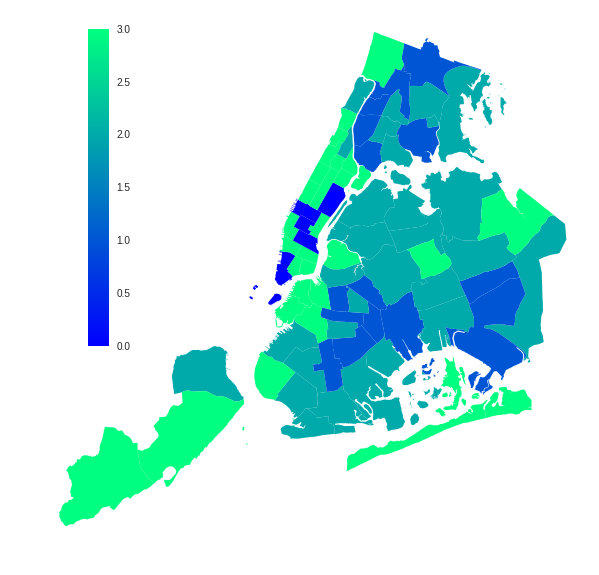

In [55]:
# plot cloropleth of socioceconomic feature clusters by precinct
crimeshp_ACS['clust_cops'] = km_krime.labels_
cp.choroplethNYC(crimeshp_ACS, column="clust_cops", cmap="winter");

__*Figure 9: Cloropleth of the K-Means cluster labels by NYC precinct for the seven major felony offenses.*__

*When comparing to the previous cloropleth (Figure 7), we can see that some of the spatial cohesion has been preserved between clustering based on ACS features and clustering based on the crime data. The cluster in easter Brooklyn (which include parts of the Bronx) is vaguely recognizable, as are portions of Lower Manhattan, but the strict geographic trends appear to fall apart somewhat for felony counts. The spatial outliers from the socioeconomic clusters are not the same as the outliers we see here.*

*So, despite the fact that there are indeed obvious connections between crime and wealth, the connections often don't map perfectly, as seen here with major felony counts and socioeconomic indicators like unemployment and median income. Though this partial mismatch could be an artifact of the subset of years that we're looking at (for example), it's more likely a result of the messy nature of social investigation. Humanity behaves in complex ways and partakse in complex systems. Thus, we shouldn't expect the story to be so simple.*

## 2.7 At last, create a function that, for a target variable input, generates a model based on median income (medianincome), green area (green), and unemployed fraction (unemployment), and returns some parameter of model quality and the most important feature in the model.

*To create this function, we first tested out how modeling our felony offenses based on socioeconomic indicators pans out. Despite the relatively small sample and number of variable, we explore Gradient Boosted Regression for its robust characteristics toward increasingly volumnous datasets & feature counts.*

In [56]:
# standardize data and split sample into training and testing sets (60-30 split)
X1 = preprocessing.scale(econ, axis=0)
y = crimeshp_ACS['BURGLARY']
eX_tr, eX_ts, wY_tr, wY_ts = cross_validation.train_test_split(X1, crimeshp_ACS['BURGLARY'], test_size=0.3, random_state=54)

In [57]:
# conduct gradient boosted ensemble method and calculate model quality
# gbr methodology inspired by Lab 12
# source: https://github.com/fedhere/PUI2017_fb55/blob/master/Lab12_fb55/LocationLocationLocation.ipynb
gbr = ensemble.GradientBoostingRegressor(max_depth=4)
gbreg1hot = gbr.fit(eX_tr, wY_tr)
print ("regression: out of sample score of gradient boosted numerical encoding in-sample %.2f, out-sample %.2f"%(
        gbreg1hot.score(eX_tr, wY_tr), gbreg1hot.score(eX_ts, wY_ts)))
print ("in-sample score of gradient boosted regression %.2f"%gbreg1hot.score(X1 ,y))

regression: out of sample score of gradient boosted numerical encoding in-sample 1.00, out-sample -0.48
in-sample score of gradient boosted regression 0.68


In [58]:
# assess feature importance and rank the socioeconomic variables accordingly
importancesgbc = gbreg1hot.feature_importances_
indicesgbc = np.argsort(importancesgbc)[::-1]

print("Feature ranking:")
for f in range(X1.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indicesgbc[f], econ.columns[indicesgbc[f]], 
          importancesgbc[indicesgbc[f]]))

Feature ranking:
1. feature 2 unemployment (0.377283)
2. feature 1 medianincome (0.370867)
3. feature 0 green (0.251850)


*The resultant function accepts a variable input (e.g. Burglary, Rape, Murder, Total Crime), generates a model based on socioeconomic indicators (e.g. medianincome, green, unemployment), and returns a parameter of model quality & feature importance.*

In [59]:
def predpol(df, target):
    '''generates model based on socioeconomic indicators
    Arguments:
    df - a valid pandas dataframe
    target - target variable input
    Returns:
    model quality and feature importance
    NOTES:
    designed for consolidated socioeconomic & target variable dataframes, 
    tested only with crime features'''
    var_home = pd.DataFrame(df)
    colM = str(target).upper().replace(' ', '')
    
    gr_gr_wk = var_home[['green', 'medianincome', 'unemployment']]

    # whitening
    X1 = preprocessing.scale(gr_gr_wk, axis=0)
    y = var_home[colM]
    
    # train/test
    # split sample into training and testing sets (60-30 split)
    eX_tr, eX_ts, wY_tr, wY_ts = cross_validation.train_test_split(X1, y, test_size=0.3, random_state=54)
    
    # gradient boosted tree regression model
    gbr = ensemble.GradientBoostingRegressor(max_depth=4)
    gbr_x = gbr.fit(eX_tr, wY_tr)
    
    qi = print ("in-sample score of gradient-boosted regression: {0:.2f}".format(gbr_x.score(X1 ,y)))
    qo = print ("out-of-sample score of gradient-boosted numerical encoding: in-sample {0:.2f}, out-sample {0:.2f}".
                format(gbr_x.score(eX_tr, wY_tr), gbr_x.score(eX_ts, wY_ts)))
    
    importancesgbc = gbr_x.feature_importances_
    indicesgbc = np.argsort(importancesgbc)[::-1]            
    
    importance = print("\nFeature ranking:")

    for f in range(X1.shape[1]):
        print("%d. %s (%f)" % (f + 1, gr_gr_wk.columns[indicesgbc[f]], importancesgbc[indicesgbc[f]]))
    
    return importance, qi, qo

In [60]:
predpol(crimeshp_ACS, 'Burglary')

in-sample score of gradient-boosted regression: 0.68
out-of-sample score of gradient-boosted numerical encoding: in-sample 1.00, out-sample 1.00

Feature ranking:
1. unemployment (0.381917)
2. medianincome (0.367461)
3. green (0.250622)


(None, None, None)

In [61]:
predpol(crimeshp_ACS, 'Rape')

in-sample score of gradient-boosted regression: 0.79
out-of-sample score of gradient-boosted numerical encoding: in-sample 1.00, out-sample 1.00

Feature ranking:
1. medianincome (0.382622)
2. unemployment (0.382449)
3. green (0.234929)


(None, None, None)

In [62]:
predpol(crimeshp_ACS, 'Murder & Non Negl. Manslaughter')

in-sample score of gradient-boosted regression: 0.89
out-of-sample score of gradient-boosted numerical encoding: in-sample 1.00, out-sample 1.00

Feature ranking:
1. medianincome (0.392227)
2. unemployment (0.369541)
3. green (0.238232)


(None, None, None)

In [63]:
predpol(crimeshp_ACS, 'Total Seven Major Felony Offenses')

in-sample score of gradient-boosted regression: 0.83
out-of-sample score of gradient-boosted numerical encoding: in-sample 1.00, out-sample 1.00

Feature ranking:
1. unemployment (0.380738)
2. medianincome (0.360004)
3. green (0.259259)


(None, None, None)

*As has become blatantly obvious from these four variable inputs, 'median income' is the most important feature for predicting each of the major felony offenses that we've fed it: Burglary, Rape, Murder, and the Total for all seven major felonies. It bears repeating that this function was designed to be robust to larger datasets and feature collections. Cross-validation gives us a better sense of the quality here, but from the scores on test and training sub-samples, it's fairly evident that our models are overfitting the data. As a next step, we could investigate the gradient boosted model further and prune. Feature importance nonetheless remains critical: what we've learned from the function exercise is that 'median income' consistently contributes in the biggest way to the regression. It's our most reliable predictor for these seven major felonies.*

*And with that, we return full circle and acknowledge the tasks we set out to grapple with initially - to explore and model NYC crime. We've conducted an exploratory analysis of seven major felonies committed in New York City over the time period 2000-2016. We've also drawn interesting and insightful linkages between a handful of valuable socioeconomic features and individual felony rates to the precinct level. We've thoroughly appreciated the opportunity to engage with this topic of urban science from the angle of urban informatics, and hope the principles we've acquired along the way have served us well.*